In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("./split/train.csv")

In [3]:
dev = pd.read_csv("./split/dev.csv")

In [41]:
test = pd.read_csv("./split/test.csv")

In [42]:
dataset = pd.read_csv("../data/train.csv")

In [47]:
companies = pd.Series(dataset["company1"].append(dataset["company2"]).value_counts().keys().values)
companies[:5]

0                   YouTube
1                    Google
2                Amazon.com
3    Verizon_Communications
4            Alexa_Internet
dtype: object

In [48]:
TEXT = "aliased_snippet"
RESULT = "is_parent"

In [50]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT]).append(companies)
corpus.shape

(79834,)

In [14]:
train[:5]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet
0,51579,Pfizer,Medivation,True,What Will Pfizer Gain FromMedivationn Inc Win...,what will company1 gain fromcompany2n inc win...
1,40891,The_Walt_Disney_Company,NBCUniversal,False,One media executive said it may be difficult ...,one media executive said it may be difficult ...
2,30797,AT&T,DirecTV,True,\nFailure of Comcast?s merger could also press...,\nfailure of comcast?s merger could also press...
3,70215,DStv,MultiChoice,False,MultiChoicee Ghana adds more local channels on...,company2e ghana adds more local channels oncom...
4,39242,Google,AT&T,False,"While Google won that battle, AT&T filed a la...","while company1 won that battle, company2 file..."


In [9]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [31]:
from sklearn.metrics import log_loss

In [96]:
from sklearn.base import TransformerMixin,  BaseEstimator
# work in progress The idea is to train on the whole corpus and transofrm what is passed
class VectFeed(TransformerMixin,BaseEstimator):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        self.fitted = False
    def transform(X, **kwargs):
        return self
        vectorizer.set_params(**kwargs)
        if not self.fitted:
            self.vectorizer.fit(corpus)
            self.fitted = True
           
        return self.vectorizer.transoform(X)
            
        return vectorizer.transform(X)
    def fit(X, y=None, **kwargs):
        return self

In [97]:
def try_pipeline(pipeline, X, y, X_test, y_test):
    params = {
        "vect__input": corpus
    }
    
    pipeline.fit(X, y)
    
    predictions = pipeline.predict(X)
    print("Score on train set is:{}".format(pipeline.score(X,y)))
    print("Log loss on train set is:{}".format(log_loss(y, predictions)))
    plot_confusion_matrix(y, predictions, classes=[0,1], normalize=True)
    predictions = pipeline.predict(X_test)
    print("Score on dev set is:{}".format(pipeline.score(X_test, y_test)))
    print("Log loss on dev setis:{}".format(log_loss(y_test, predictions)))
    plot_confusion_matrix(y_test, predictions, classes=[0,1],normalize=True)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Score on train set is:0.7343974949611287
Log loss on train set is:9.173615807037862


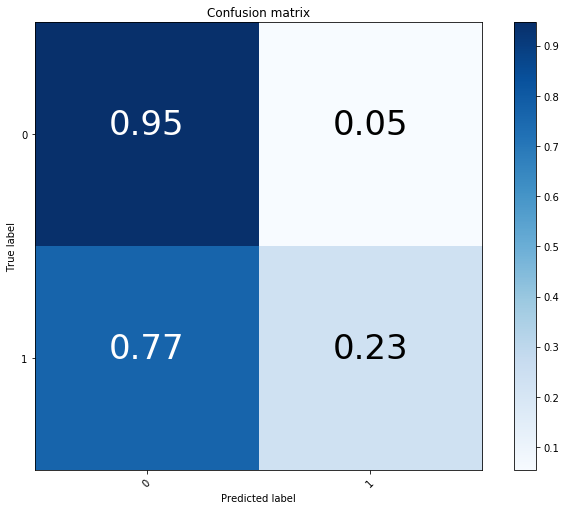

Score on dev set is:0.6789493575207861
Log loss on dev setis:11.088752156639732


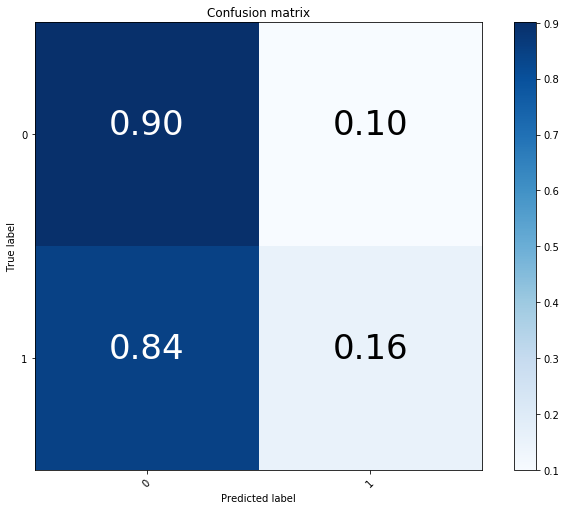

In [99]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("classifier", LogisticRegression())
])

try_pipeline(pipeline, train[TEXT], train[RESULT], dev[TEXT], dev[RESULT])

Score on train set is:0.7738266628275267
Log loss on train set is:7.811795473437472


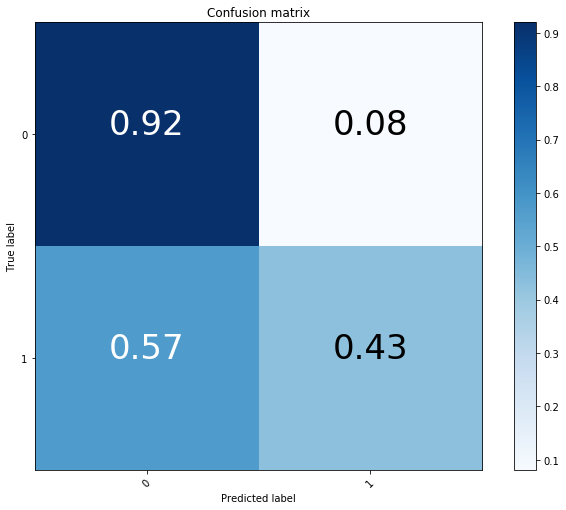

Score on dev set is:0.6071428571428571
Log loss on dev setis:13.568927601108781


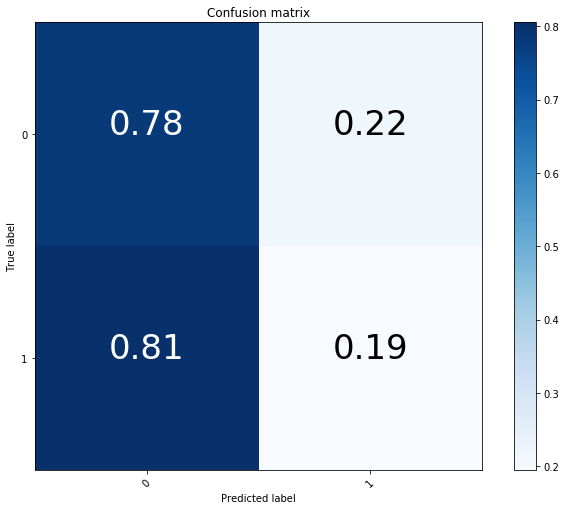

In [76]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("classifier", LinearSVC())
])

try_pipeline(pipeline, train[TEXT], train[RESULT], dev[TEXT], dev[RESULT])

Score on train set is:0.716347538151454
Log loss on train set is:9.797017256411953


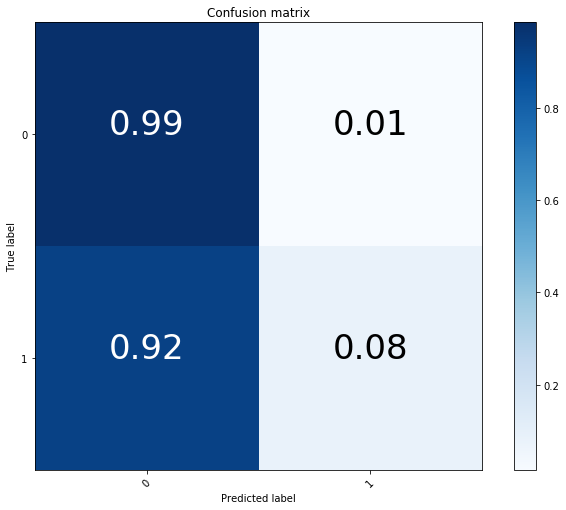

Score on dev set is:0.6909800957420005
Log loss on dev setis:10.673185693058654


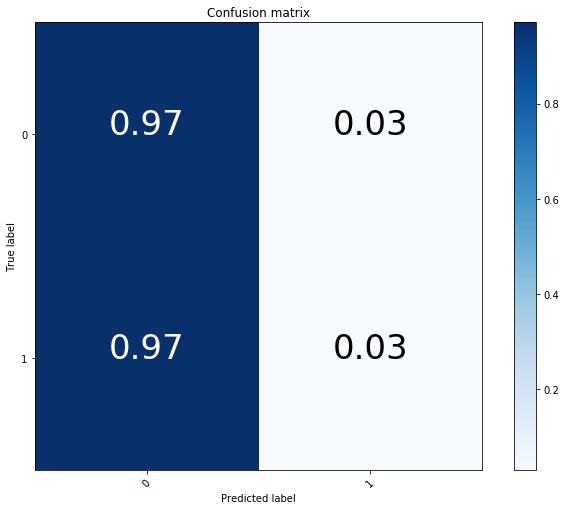

In [37]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("classifier", MultinomialNB())
])

try_pipeline(pipeline, train[TEXT], train[RESULT], dev[TEXT], dev[RESULT])

It seems the multinomial nb sucks for some reason (someone should check the pipeline)

I will just check how count vectorizer changes the results when using LinearSVC for model

Score on train set is:0.7915706881658509
Log loss on train set is:7.198946665626658


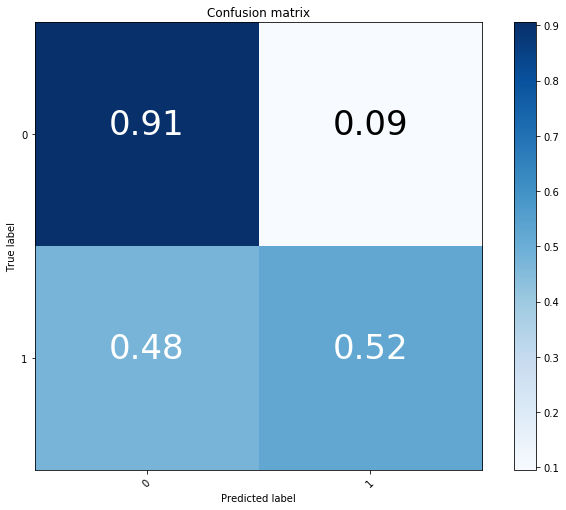

Score on dev set is:0.5577601410934744
Log loss on dev setis:15.274586581377678


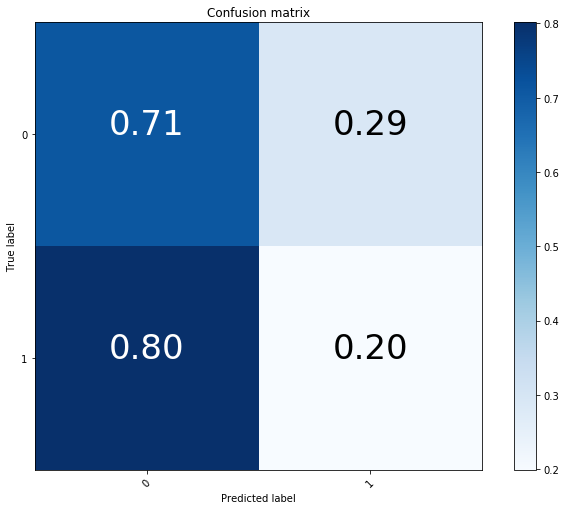

In [36]:
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("classifier", LinearSVC())
])

try_pipeline(pipeline, train[TEXT], train[RESULT], dev[TEXT], dev[RESULT])

Lastly I will check what goes on when using linear naive b

In [39]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [40]:
def get_mdl(train, y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = train.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
corpus = pd.read_csv("../data/train.csv")
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
vec.fit(corpus)